# Análisis Comparativo de Algoritmos para Selección Óptima de Talento

En este notebook se evalúan y comparan los diferentes algoritmos implementados para resolver el problema de selección óptima de freelancers, generando instancias de prueba y visualizando los resultados mediante gráficos y tablas comparativas.

## 1. Importaciones y Configuración

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Type
import warnings
warnings.filterwarnings('ignore')

# Importar clases del proyecto
from elements.employee import Employee
from elements.client import Client
from elements.skills import Skill
from solver.backtrack_with_cut import BacktrackSolver
from solver.greedy_solver import GreedySolver
from solver.dp_solver import DPSolver
from solver.oracle_solver import OracleSolver
from tester.instance_generator import InstanceGenerator
from tester.problem_tester import ProblemTester
from tester.metrics_collector import MetricsCollector

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Todas las librerías importadas correctamente")

✓ Todas las librerías importadas correctamente


## 2. Backtracking con Poda (Branch and Bound)

**Descripción:** El algoritmo de Backtracking explora el espacio de soluciones de forma sistemática, construyendo subconjuntos de empleados y verificando si cumplen los requisitos. Implementa dos estrategias de poda inteligentes:

1. **Poda por Costo:** Si el costo acumulado supera el mejor costo encontrado, la rama se descarta.
2. **Poda por Factibilidad:** Si los empleados restantes no pueden cubrir los requisitos pendientes, la rama se elimina.

**Complejidad:** $O(2^n)$ en el peor caso, pero significativamente mejorada en la práctica con las podas.

**Garantía:** Encuentra la solución óptima.

## 3. Experimento 1: Evaluación de Backtracking

Se ejecuta el algoritmo Backtracking sobre instancias de tamaño creciente para analizar su rendimiento.

In [2]:
# Generador de instancias para reproducibilidad
generator = InstanceGenerator(seed=42, min_salary=10, max_salary=100)

# Crear instancia de prueba
employees = generator.generate_employees(n=10, min_skills=2, max_skills=5)
client = generator.generate_client(min_req=2, max_req=4)

# Ejecutar Backtracking
backtrack_solver = BacktrackSolver(employees, client)
solution = backtrack_solver.solve()

print(f"Problema de ejemplo:")
print(f"  Empleados disponibles: {len(employees)}")
print(f"  Requisitos del cliente: {len(client.requirements)}")
print(f"\nSolución Backtracking:")
print(f"  ✓ Válida: {solution.is_valid}")
print(f"  Costo total: ${solution.total_cost:.2f}")
print(f"  Empleados seleccionados: {len(solution.employees)}")
for emp in solution.employees:
    print(f"    - {emp.name}: ${emp.salary_per_hour}/h")

Problema de ejemplo:
  Empleados disponibles: 10
  Requisitos del cliente: 4

Solución Backtracking:
  ✓ Válida: True
  Costo total: $53.00
  Empleados seleccionados: 1
    - Employee_5: $53/h


### Gráficos de Rendimiento de Backtracking

In [3]:
# Generar tester y registrar solvers
metrics = MetricsCollector()
tester = ProblemTester(generator, metrics)
tester.add_solver(BacktrackSolver)

# Ejecutar experimento con tamaños crecientes
print("Ejecutando experimento con Backtracking...")
employee_sizes = [8, 10, 12, 14, 16]
results_backtrack = tester.run_experiment(
    employee_sizes=employee_sizes,
    repetitions=3,
    min_requirements=2,
    max_requirements=4,
    verbose=True
)

# Convertir a DataFrame
df_backtrack = pd.DataFrame(results_backtrack)
print(f"\n✓ Experimento completado: {len(df_backtrack)} evaluaciones")

Ejecutando experimento con Backtracking...
[1/15] BacktrackSolver - n=8, rep=1
[2/15] BacktrackSolver - n=8, rep=2
[3/15] BacktrackSolver - n=8, rep=3
[4/15] BacktrackSolver - n=10, rep=1
[5/15] BacktrackSolver - n=10, rep=2
[6/15] BacktrackSolver - n=10, rep=3
[7/15] BacktrackSolver - n=12, rep=1
[8/15] BacktrackSolver - n=12, rep=2
[9/15] BacktrackSolver - n=12, rep=3
[10/15] BacktrackSolver - n=14, rep=1
[11/15] BacktrackSolver - n=14, rep=2
[12/15] BacktrackSolver - n=14, rep=3
[13/15] BacktrackSolver - n=16, rep=1
[14/15] BacktrackSolver - n=16, rep=2
[15/15] BacktrackSolver - n=16, rep=3

✓ Experimento completado: 15 evaluaciones


### Tabla de Estadísticas - Backtracking

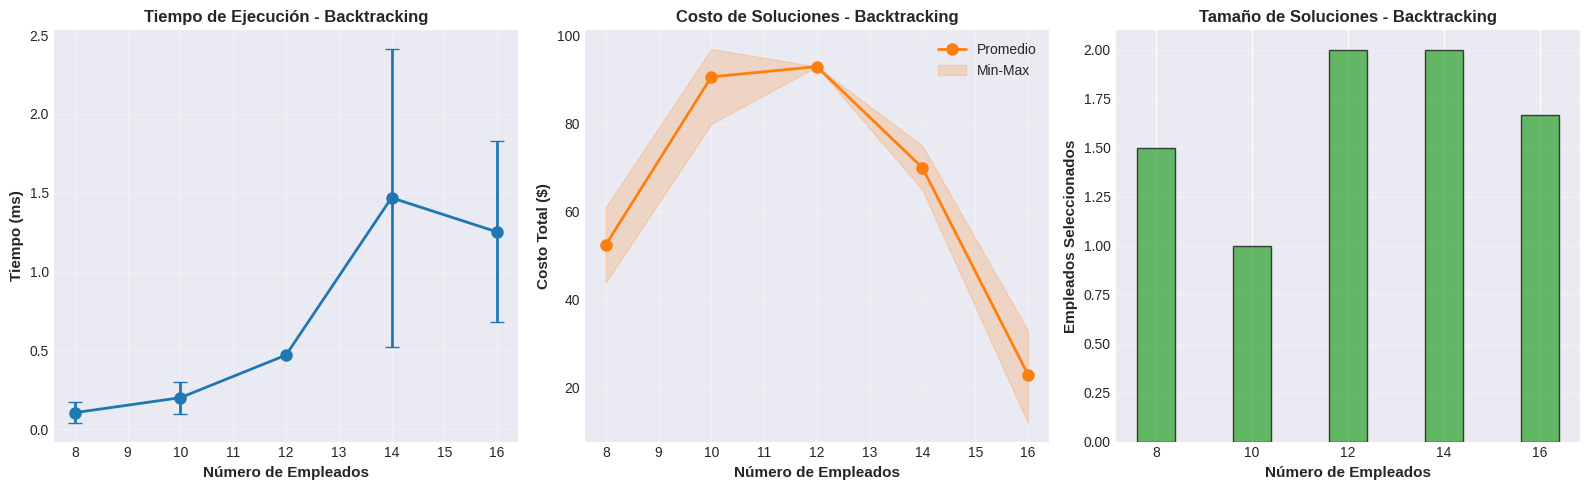

✓ Gráficos generados exitosamente


In [4]:
# Filtrar solo resultados válidos
df_backtrack_valid = df_backtrack[df_backtrack['is_valid']]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Tiempo de ejecución vs tamaño de instancia
time_data = df_backtrack_valid.groupby('num_employees')['time_seconds'].agg(['mean', 'std'])
axes[0].errorbar(time_data.index, time_data['mean']*1000, 
                 yerr=time_data['std']*1000, marker='o', capsize=5, linewidth=2, markersize=8, color='#1f77b4')
axes[0].set_xlabel('Número de Empleados', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Tiempo (ms)', fontsize=11, fontweight='bold')
axes[0].set_title('Tiempo de Ejecución - Backtracking', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Costo de la solución
cost_data = df_backtrack_valid.groupby('num_employees')['solution_cost'].agg(['mean', 'min', 'max'])
axes[1].plot(cost_data.index, cost_data['mean'], marker='o', linewidth=2, markersize=8, label='Promedio', color='#ff7f0e')
axes[1].fill_between(cost_data.index, cost_data['min'], cost_data['max'], alpha=0.2, color='#ff7f0e', label='Min-Max')
axes[1].set_xlabel('Número de Empleados', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Costo Total ($)', fontsize=11, fontweight='bold')
axes[1].set_title('Costo de Soluciones - Backtracking', fontsize=12, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# 3. Tamaño de la solución (número de empleados seleccionados)
size_data = df_backtrack_valid.groupby('num_employees')['solution_size'].mean()
axes[2].bar(size_data.index, size_data.values, color='#2ca02c', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Número de Empleados', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Empleados Seleccionados', fontsize=11, fontweight='bold')
axes[2].set_title('Tamaño de Soluciones - Backtracking', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Gráficos generados exitosamente")

## 4. Experimento 2: Comparación de Todos los Algoritmos

Se comparan los diferentes algoritmos implementados sobre las mismas instancias.

In [5]:
# Crear tabla de estadísticas
stats_backtrack = df_backtrack_valid.groupby('num_employees').agg({
    'time_seconds': ['mean', 'min', 'max'],
    'solution_cost': ['mean', 'min', 'max'],
    'solution_size': ['mean'],
    'is_valid': 'count'
}).round(4)

stats_backtrack.columns = ['Tiempo Prom (s)', 'Tiempo Min (s)', 'Tiempo Max (s)',
                            'Costo Prom ($)', 'Costo Min ($)', 'Costo Max ($)',
                            'Tamaño Prom', 'Evaluaciones']

# Convertir tiempos a ms para mejor legibilidad
stats_backtrack['Tiempo Prom (ms)'] = (stats_backtrack['Tiempo Prom (s)'] * 1000).round(2)
stats_backtrack['Tiempo Min (ms)'] = (stats_backtrack['Tiempo Min (s)'] * 1000).round(2)
stats_backtrack['Tiempo Max (ms)'] = (stats_backtrack['Tiempo Max (s)'] * 1000).round(2)
stats_backtrack = stats_backtrack.drop(['Tiempo Prom (s)', 'Tiempo Min (s)', 'Tiempo Max (s)'], axis=1)

print("\n" + "="*100)
print("ESTADÍSTICAS DE BACKTRACKING")
print("="*100)
print(stats_backtrack.to_string())
print("="*100)


ESTADÍSTICAS DE BACKTRACKING
               Costo Prom ($)  Costo Min ($)  Costo Max ($)  Tamaño Prom  Evaluaciones  Tiempo Prom (ms)  Tiempo Min (ms)  Tiempo Max (ms)
num_employees                                                                                                                             
8                     52.5000           44.0           61.0       1.5000             2               0.1              0.1              0.2
10                    90.6667           80.0           97.0       1.0000             3               0.2              0.1              0.3
12                    93.0000           93.0           93.0       2.0000             1               0.5              0.5              0.5
14                    70.0000           65.0           75.0       2.0000             2               1.5              0.8              2.1
16                    23.0000           12.0           33.0       1.6667             3               1.3              0.8              1

### Gráficos Comparativos

In [6]:
# Crear nuevo tester para comparación completa
metrics_all = MetricsCollector()
tester_all = ProblemTester(generator, metrics_all)

# Registrar todos los solvers
tester_all.add_solvers(
    BacktrackSolver,
    GreedySolver,
    DPSolver,
    OracleSolver
)

print("Ejecutando experimento comparativo con todos los algoritmos...")
employee_sizes_comp = [8, 10, 12]
results_all = tester_all.run_experiment(
    employee_sizes=employee_sizes_comp,
    repetitions=3,
    min_requirements=2,
    max_requirements=4,
    verbose=True
)

df_all = pd.DataFrame(results_all)
print(f"\n✓ Experimento completado: {len(df_all)} evaluaciones")

Ejecutando experimento comparativo con todos los algoritmos...
[1/36] BacktrackSolver - n=8, rep=1
[2/36] GreedySolver - n=8, rep=1
[3/36] DPSolver - n=8, rep=1
[4/36] OracleSolver - n=8, rep=1
[5/36] BacktrackSolver - n=8, rep=2
[6/36] GreedySolver - n=8, rep=2
[7/36] DPSolver - n=8, rep=2
[8/36] OracleSolver - n=8, rep=2
[9/36] BacktrackSolver - n=8, rep=3
[10/36] GreedySolver - n=8, rep=3
[11/36] DPSolver - n=8, rep=3
[12/36] OracleSolver - n=8, rep=3
[13/36] BacktrackSolver - n=10, rep=1
[14/36] GreedySolver - n=10, rep=1
[15/36] DPSolver - n=10, rep=1
[16/36] OracleSolver - n=10, rep=1
[17/36] BacktrackSolver - n=10, rep=2
[18/36] GreedySolver - n=10, rep=2
[19/36] DPSolver - n=10, rep=2
[20/36] OracleSolver - n=10, rep=2
[21/36] BacktrackSolver - n=10, rep=3
[22/36] GreedySolver - n=10, rep=3
[23/36] DPSolver - n=10, rep=3
[24/36] OracleSolver - n=10, rep=3
[25/36] BacktrackSolver - n=12, rep=1
[26/36] GreedySolver - n=12, rep=1
[27/36] DPSolver - n=12, rep=1
[28/36] OracleSolver

## 5. Resumen Completo Usando MetricsCollector

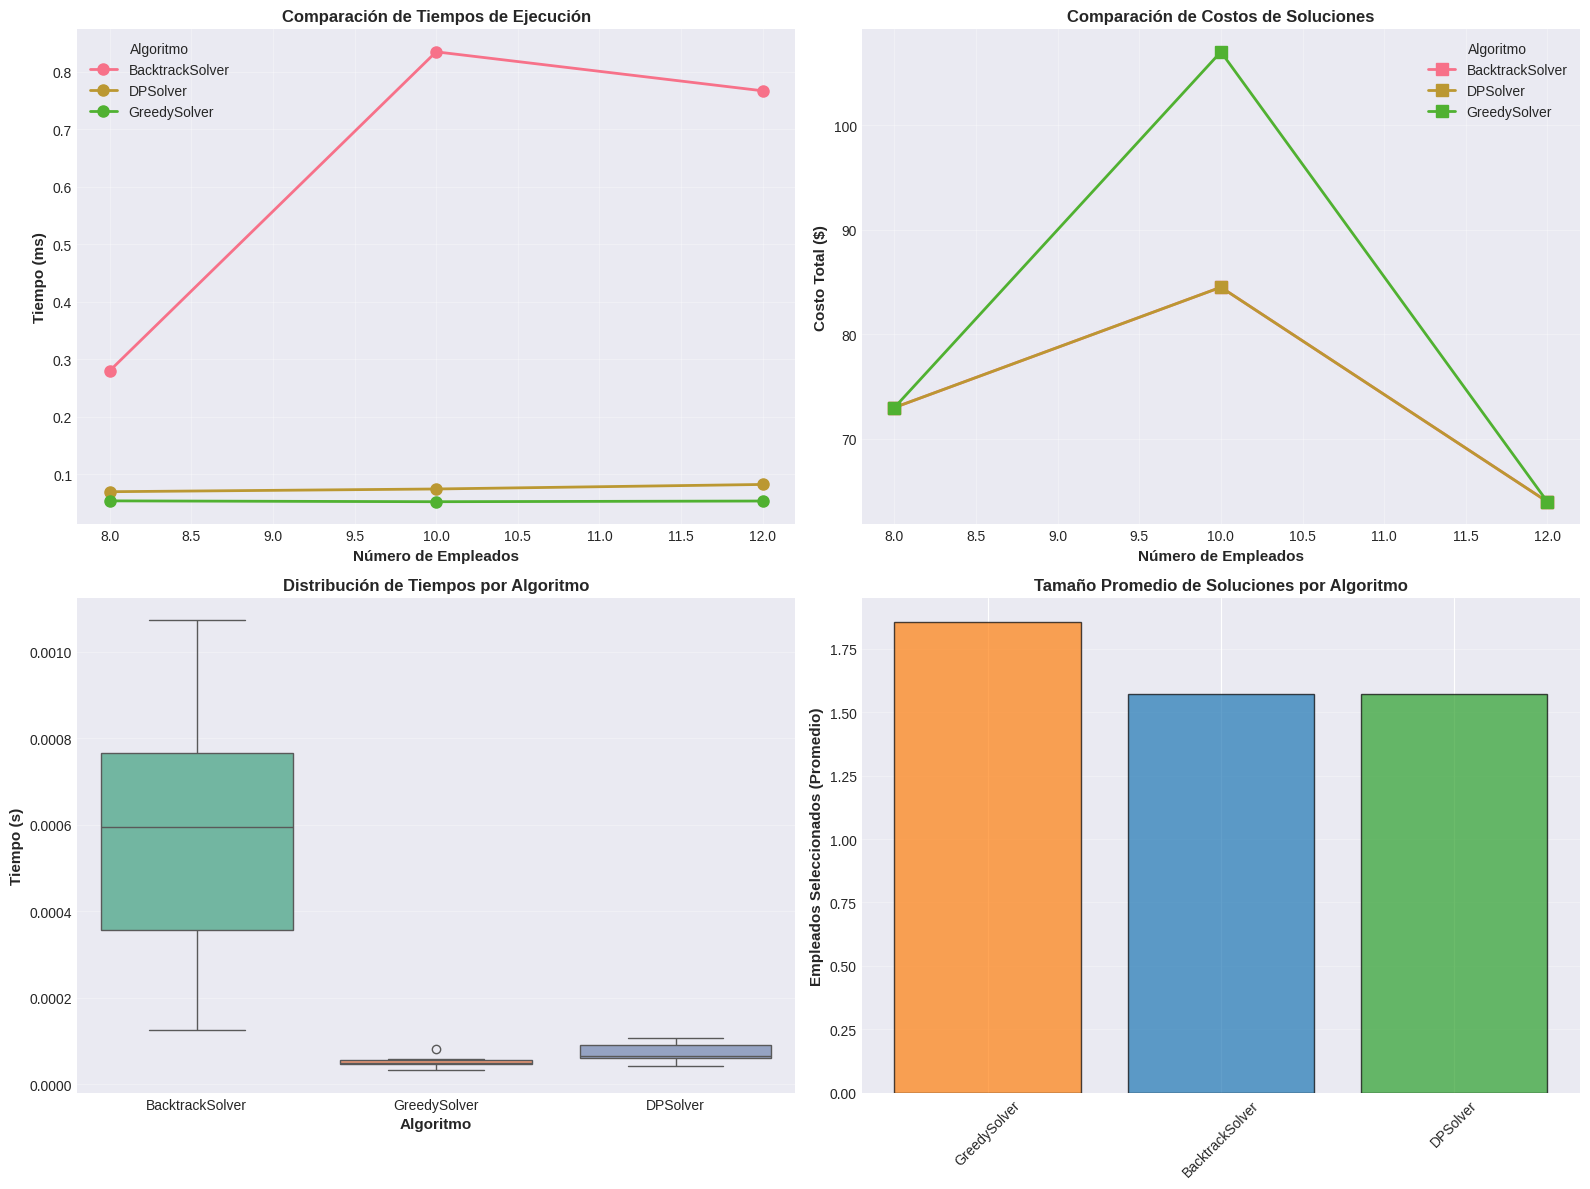

✓ Gráficos comparativos generados exitosamente


In [7]:
# Filtrar resultados válidos
df_all_valid = df_all[df_all['is_valid']]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de Tiempos
time_comparison = df_all_valid.groupby(['num_employees', 'algorithm'])['time_seconds'].mean().unstack() * 1000
time_comparison.plot(ax=axes[0, 0], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Número de Empleados', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Tiempo (ms)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Comparación de Tiempos de Ejecución', fontsize=12, fontweight='bold')
axes[0, 0].legend(title='Algoritmo', loc='best')
axes[0, 0].grid(True, alpha=0.3)

# 2. Comparación de Costos
cost_comparison = df_all_valid.groupby(['num_employees', 'algorithm'])['solution_cost'].mean().unstack()
cost_comparison.plot(ax=axes[0, 1], marker='s', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Número de Empleados', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Costo Total ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Comparación de Costos de Soluciones', fontsize=12, fontweight='bold')
axes[0, 1].legend(title='Algoritmo', loc='best')
axes[0, 1].grid(True, alpha=0.3)

# 3. Boxplot de Tiempos por Algoritmo
sns.boxplot(data=df_all_valid, x='algorithm', y='time_seconds', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_xlabel('Algoritmo', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Tiempo (s)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribución de Tiempos por Algoritmo', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Barplot de Tamaño de Solución Promedio
size_comparison = df_all_valid.groupby('algorithm')['solution_size'].mean().sort_values(ascending=False)
colors_size = ['#1f77b4' if x == 'BacktrackSolver' else '#ff7f0e' if x == 'GreedySolver' else '#2ca02c' if x == 'DPSolver' else '#d62728' for x in size_comparison.index]
axes[1, 1].bar(size_comparison.index, size_comparison.values, color=colors_size, edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Empleados Seleccionados (Promedio)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Tamaño Promedio de Soluciones por Algoritmo', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Gráficos comparativos generados exitosamente")

### Tabla Detallada Comparativa

In [8]:
# Obtener resumen completo de todos los resultados
summary = metrics_all.get_summary()

# Convertir a DataFrame para mejor visualización
summary_df = pd.DataFrame(summary).T
summary_df = summary_df.round(4)

# Reordenar columnas para legibilidad
summary_df = summary_df[[
    'total_runs',
    'valid_solutions',
    'avg_time',
    'min_time',
    'max_time',
    'avg_cost',
    'min_cost',
    'max_cost'
]]

# Renombrar columnas
summary_df.columns = [
    'Total Ejecuciones',
    'Soluciones Válidas',
    'Tiempo Prom (s)',
    'Tiempo Min (s)',
    'Tiempo Max (s)',
    'Costo Prom ($)',
    'Costo Min ($)',
    'Costo Max ($)'
]

# Convertir tiempos a milisegundos
summary_df['Tiempo Prom (ms)'] = (summary_df['Tiempo Prom (s)'] * 1000).round(2)
summary_df['Tiempo Min (ms)'] = (summary_df['Tiempo Min (s)'] * 1000).round(2)
summary_df['Tiempo Max (ms)'] = (summary_df['Tiempo Max (s)'] * 1000).round(2)
summary_df = summary_df.drop(['Tiempo Prom (s)', 'Tiempo Min (s)', 'Tiempo Max (s)'], axis=1)

print("\n" + "="*130)
print("RESUMEN COMPARATIVO DE TODOS LOS ALGORITMOS")
print("="*130)
print(summary_df.to_string())
print("="*130)


RESUMEN COMPARATIVO DE TODOS LOS ALGORITMOS
                 Total Ejecuciones  Soluciones Válidas  Costo Prom ($)  Costo Min ($)  Costo Max ($)  Tiempo Prom (ms)  Tiempo Min (ms)  Tiempo Max (ms)
BacktrackSolver                9.0                 7.0         73.7143           12.0          116.0               0.5              0.0              1.1
DPSolver                       9.0                 7.0         73.7143           12.0          116.0               0.1              0.0              0.1
GreedySolver                   9.0                 7.0         80.1429           12.0          126.0               0.1              0.0              0.1


## 6. Análisis de Resultados y Conclusiones

In [9]:
# Crear tabla con datos más granulares por tamaño de instancia
detailed_comparison = df_all_valid.groupby(['num_employees', 'algorithm']).agg({
    'time_seconds': 'mean',
    'solution_cost': 'mean',
    'solution_size': 'mean',
    'is_valid': 'count'
}).round(4)

detailed_comparison.columns = ['Tiempo Prom (s)', 'Costo Prom ($)', 'Tamaño Prom', 'Ejecuciones']
detailed_comparison['Tiempo Prom (ms)'] = (detailed_comparison['Tiempo Prom (s)'] * 1000).round(2)
detailed_comparison = detailed_comparison.drop('Tiempo Prom (s)', axis=1)

print("\n" + "="*100)
print("COMPARACIÓN DETALLADA POR TAMAÑO DE INSTANCIA")
print("="*100)
print(detailed_comparison.to_string())
print("="*100)


COMPARACIÓN DETALLADA POR TAMAÑO DE INSTANCIA
                               Costo Prom ($)  Tamaño Prom  Ejecuciones  Tiempo Prom (ms)
num_employees algorithm                                                                  
8             BacktrackSolver            73.0       1.6667            3               0.3
              DPSolver                   73.0       1.6667            3               0.1
              GreedySolver               73.0       1.6667            3               0.1
10            BacktrackSolver            84.5       1.0000            2               0.8
              DPSolver                   84.5       1.0000            2               0.1
              GreedySolver              107.0       2.0000            2               0.1
12            BacktrackSolver            64.0       2.0000            2               0.8
              DPSolver                   64.0       2.0000            2               0.1
              GreedySolver               64.0       2

In [10]:
print("\n" + "="*80)
print("ANÁLISIS Y CONCLUSIONES")
print("="*80)

# Análisis por algoritmo
for algo in df_all_valid['algorithm'].unique():
    algo_data = df_all_valid[df_all_valid['algorithm'] == algo]
    valid_count = algo_data['is_valid'].sum()
    avg_time = algo_data['time_seconds'].mean() * 1000
    avg_cost = algo_data[algo_data['is_valid']]['solution_cost'].mean()
    
    print(f"\n{algo}:")
    print(f"  • Soluciones válidas: {valid_count}/{len(algo_data)} ({100*valid_count/len(algo_data):.1f}%)")
    print(f"  • Tiempo promedio: {avg_time:.2f} ms")
    print(f"  • Costo promedio: ${avg_cost:.2f}")

# Comparación de optimalidad
print("\n" + "-"*80)
print("ANÁLISIS DE OPTIMALIDAD:")
backtrack_cost = df_all_valid[df_all_valid['algorithm'] == 'BacktrackSolver']['solution_cost'].mean()
for algo in df_all_valid['algorithm'].unique():
    if algo != 'BacktrackSolver':
        algo_cost = df_all_valid[df_all_valid['algorithm'] == algo]['solution_cost'].mean()
        diff = algo_cost - backtrack_cost
        pct_diff = (diff / backtrack_cost) * 100 if backtrack_cost > 0 else 0
        print(f"  • {algo} vs Backtracking: {pct_diff:+.2f}% ({diff:+.2f}$)")

print("\n" + "="*80)


ANÁLISIS Y CONCLUSIONES

BacktrackSolver:
  • Soluciones válidas: 7/7 (100.0%)
  • Tiempo promedio: 0.58 ms
  • Costo promedio: $73.71

GreedySolver:
  • Soluciones válidas: 7/7 (100.0%)
  • Tiempo promedio: 0.05 ms
  • Costo promedio: $80.14

DPSolver:
  • Soluciones válidas: 7/7 (100.0%)
  • Tiempo promedio: 0.07 ms
  • Costo promedio: $73.71

--------------------------------------------------------------------------------
ANÁLISIS DE OPTIMALIDAD:
  • GreedySolver vs Backtracking: +8.72% (+6.43$)
  • DPSolver vs Backtracking: +0.00% (+0.00$)

